<a href="https://colab.research.google.com/github/SanthoshiRavi/Healthcare-Text-Processing-/blob/main/Healthcare_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests

In [ ]:
pip install beautifulsoup4

In [ ]:
pip install nltk

In [ ]:
import requests

def fetch_pubmed_article_ids(query, api_key, max_results=100):
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&api_key={api_key}&retmode=json'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        ids = data['esearchresult']['idlist']
        return ids
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

# Your API key
api_key = '14b3330cab5a4aabaefc418267dd19492909'
# Query term
query = 'diabetes treatment'
# Fetch article IDs
article_ids = fetch_pubmed_article_ids(query, api_key)
print("Article IDs fetched:")
print(article_ids)


Article IDs fetched:
['38760852', '38760705', '38760678', '38760661', '38760632', '38760595', '38760456', '38760452', '38760427', '38760383', '38760126', '38760125', '38760053', '38760035', '38760033', '38759989', '38759983', '38759874', '38759763', '38759722', '38759707', '38759658', '38759515', '38759430', '38759418', '38759318', '38759315', '38759226', '38759099', '38758937', '38758936', '38758907', '38758866', '38758863', '38758855', '38758848', '38758847', '38758689', '38758687', '38758679', '38758678', '38758675', '38758674', '38758639', '38758517', '38758435', '38758423', '38758248', '38758212', '38758211', '38758187', '38758154', '38758099', '38757999', '38757954', '38757950', '38757904', '38757902', '38757785', '38757729', '38757725', '38757633', '38757582', '38757550', '38757431', '38757421', '38757360', '38757342', '38757316', '38757277', '38757211', '38757202', '38757185', '38757094', '38757051', '38756658', '38756527', '38756477', '38756429', '38756426', '38756391', '38756

In [ ]:
def fetch_pubmed_article_details(article_ids, api_key):
    ids = ','.join(article_ids)
    url = f'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={ids}&api_key={api_key}&retmode=xml'
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

article_details_xml = fetch_pubmed_article_details(article_ids, api_key)
print("Fetched article details in XML format.")


Fetched article details in XML format.


In [ ]:
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def parse_article_details(article_xml):
    soup = BeautifulSoup(article_xml, 'xml')
    articles = soup.find_all('PubmedArticle')
    parsed_data = []
    for article in articles:
        title = article.find('ArticleTitle').text if article.find('ArticleTitle') else ""
        abstract = article.find('AbstractText').text if article.find('AbstractText') else ""
        parsed_data.append((title, abstract))
    return parsed_data

parsed_articles = parse_article_details(article_details_xml)
print("Parsed articles:")
print(parsed_articles[:3])  # Print the first 3 articles for verification

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

preprocessed_articles = [(preprocess_text(title), preprocess_text(abstract)) for title, abstract in parsed_articles]
print("Preprocessed articles:")
print(preprocessed_articles[:3])  # Print the first 3 preprocessed articles for verification


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Parsed articles:
[('Response to semaglutide of non-drinker subjects with type 2 diabetes.', 'Metabolic dysfunction-associated Steatotic Liver Disease (MASLD) displays a worse prognosis in subjects with type 2 diabetes (T2D); effective treatments are, so far, scanty. Semaglutide showed efficacy in improving steatohepatitis. We longitudinally observed a MASLD cohort of T2D subjects starting semaglutide, to detect an improvement of non-invasive surrogates of steatosis and fibro-inflammatory liver involvement, evaluating the role of mild alcohol consumption.'), ('Characterization of the gut microbiota in polycystic ovary syndrome with dyslipidemia.', 'Polycystic ovary syndrome (PCOS) is an endocrinopathy in childbearing-age females which can cause many complications, such as diabetes, obesity, and dyslipidemia. The metabolic disorders in patients with PCOS were linked to gut microbial dysbiosis. However, the correlation between the gut microbial community and dyslipidemia in PCOS remains u

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine title and abstract for each article
combined_texts = [f"{title} {abstract}" for title, abstract in preprocessed_articles]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the combined texts
X = vectorizer.fit_transform(combined_texts)

# Print the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (100, 1000)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 5

# Fit LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda_model.fit_transform(X)

# Print the topics and the top words in each topic
print("Topics found via LDA:")
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    print(f"Topic {idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[-10:]])


Topics found via LDA:
Topic 1:
['brain', 'subject', 'syndrome', 'insulin', 'drug', 'hfpef', 'diabetes', 'study', 'semaglutide', 'patient']
Topic 2:
['patient', 'study', 'amputation', 'diabetes', 'disease', 'foot', 'clinical', 'group', 'treatment', 'diabetic']
Topic 3:
['tdm', 'extract', 'methylation', 'orion', 'lipodystrophy', 'dress', 'diabetic', 'ulceration', 'metabolic', 'foot']
Topic 4:
['diabetes', 'treatment', 'diabetic', 'wound', 'cell', 'effect', 'disease', 'risk', 'kidney', 'patient']
Topic 5:
['opportunity', 'wound', 'type', 'group', 'challenge', 'level', 'health', 'covid', 'diabetes', 'patient']


In [ ]:
import numpy as np

# Print the topic distribution for each document
for idx, topic_distribution in enumerate(lda_topics):
    print(f"Document {idx + 1}:")
    for topic_idx, prob in enumerate(topic_distribution):
        print(f"  Topic {topic_idx + 1}: {prob:.4f}")


Document 1:
  Topic 1: 0.8285
  Topic 2: 0.0428
  Topic 3: 0.0427
  Topic 4: 0.0427
  Topic 5: 0.0433
Document 2:
  Topic 1: 0.8287
  Topic 2: 0.0430
  Topic 3: 0.0426
  Topic 4: 0.0427
  Topic 5: 0.0429
Document 3:
  Topic 1: 0.0377
  Topic 2: 0.0380
  Topic 3: 0.0377
  Topic 4: 0.8486
  Topic 5: 0.0380
Document 4:
  Topic 1: 0.0404
  Topic 2: 0.0402
  Topic 3: 0.0404
  Topic 4: 0.0402
  Topic 5: 0.8388
Document 5:
  Topic 1: 0.0352
  Topic 2: 0.8614
  Topic 3: 0.0345
  Topic 4: 0.0345
  Topic 5: 0.0344
Document 6:
  Topic 1: 0.0412
  Topic 2: 0.8358
  Topic 3: 0.0409
  Topic 4: 0.0410
  Topic 5: 0.0411
Document 7:
  Topic 1: 0.8782
  Topic 2: 0.0306
  Topic 3: 0.0303
  Topic 4: 0.0303
  Topic 5: 0.0304
Document 8:
  Topic 1: 0.0285
  Topic 2: 0.0276
  Topic 3: 0.8887
  Topic 4: 0.0275
  Topic 5: 0.0276
Document 9:
  Topic 1: 0.0350
  Topic 2: 0.0351
  Topic 3: 0.0346
  Topic 4: 0.8599
  Topic 5: 0.0355
Document 10:
  Topic 1: 0.0365
  Topic 2: 0.8566
  Topic 3: 0.0353
  Topic 4: 0.03

In [ ]:
import numpy as np

# Assign the dominant topic to each document
dominant_topics = np.argmax(lda_topics, axis=1)

# Print the dominant topic for each document
for idx, topic in enumerate(dominant_topics):
    print(f"Document {idx + 1}: Dominant Topic {topic + 1}")


Document 1: Dominant Topic 1
Document 2: Dominant Topic 1
Document 3: Dominant Topic 4
Document 4: Dominant Topic 5
Document 5: Dominant Topic 2
Document 6: Dominant Topic 2
Document 7: Dominant Topic 1
Document 8: Dominant Topic 3
Document 9: Dominant Topic 4
Document 10: Dominant Topic 2
Document 11: Dominant Topic 5
Document 12: Dominant Topic 5
Document 13: Dominant Topic 5
Document 14: Dominant Topic 1
Document 15: Dominant Topic 5
Document 16: Dominant Topic 5
Document 17: Dominant Topic 1
Document 18: Dominant Topic 4
Document 19: Dominant Topic 3
Document 20: Dominant Topic 5
Document 21: Dominant Topic 1
Document 22: Dominant Topic 2
Document 23: Dominant Topic 5
Document 24: Dominant Topic 1
Document 25: Dominant Topic 1
Document 26: Dominant Topic 2
Document 27: Dominant Topic 4
Document 28: Dominant Topic 2
Document 29: Dominant Topic 2
Document 30: Dominant Topic 3
Document 31: Dominant Topic 1
Document 32: Dominant Topic 5
Document 33: Dominant Topic 5
Document 34: Domina

In [ ]:
pip install pyLDAvis==3.3.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
import gensim.corpora as corpora

# Create a Gensim dictionary and corpus from your data
texts = [doc.split() for doc in combined_texts]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Train the LDA model using Gensim
lda_model_gensim = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=n_topics,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Prepare the pyLDAvis visualization
pyLDAvis.enable_notebook()
panel = gensimvis.prepare(lda_model_gensim, corpus, id2word)
pyLDAvis.display(panel)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


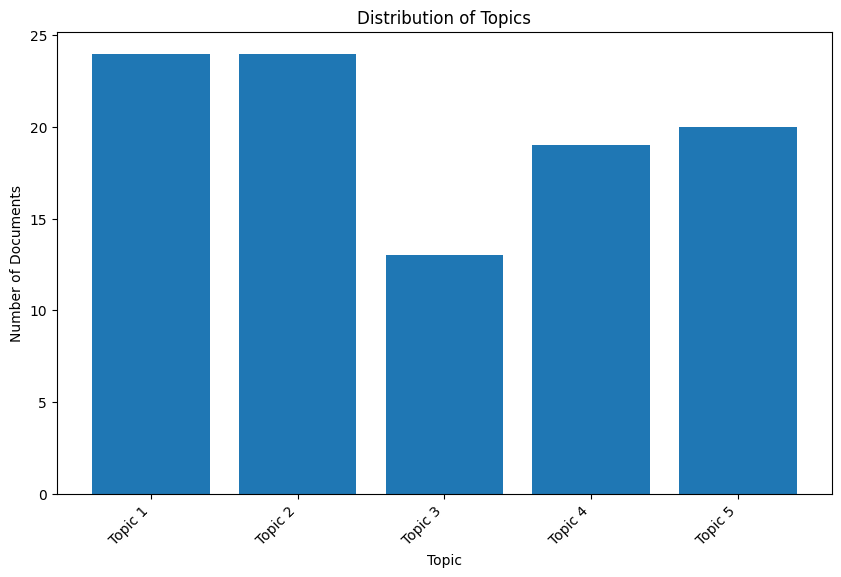

In [ ]:
import matplotlib.pyplot as plt

# Count the number of documents per topic
topic_counts = np.bincount(dominant_topics)

# Plot the distribution of topics with generic names
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_topics + 1), topic_counts, tick_label=[f'Topic {i + 1}' for i in range(n_topics)])
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Distribution of Topics')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Function to create feature vectors
def create_feature_vector(lda_corpus, num_topics):
    feature_vectors = []
    for doc in lda_corpus:
        vector = np.zeros(num_topics)
        if isinstance(doc, list):
            for topic_num, topic_prob in doc:
                vector[topic_num] = topic_prob
        feature_vectors.append(vector)
    return np.array(feature_vectors)

# Number of topics (should match the number of topics in your LDA model)
num_topics = 5

# Create feature vectors
X_topics = create_feature_vector(lda_corpus, num_topics)

# Print the shape of the feature matrix
print(f"Feature matrix shape: {X_topics.shape}")

# Ensure the labels match the number of samples in X_topics
num_samples = X_topics.shape[0]

# Example labels (replace with actual labels if available)
# Create labels to match the number of samples in X_topics
labels = ['Label1', 'Label2', 'Label3'] * ((num_samples // 3) + 1)
labels = labels[:num_samples]  # Ensure labels list matches the length of the data

# Verify lengths before encoding
print(f"Number of samples in X_topics: {len(X_topics)}")
print(f"Number of labels: {len(labels)}")
print(f"X_topics: {X_topics[:5]}")  # First 5 samples
print(f"Labels: {labels[:5]}")      # First 5 labels

# Ensure consistent lengths before encoding
assert len(X_topics) == len(labels), "Mismatch between the number of samples and labels."

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Verify lengths again after encoding
print(f"Number of encoded labels: {len(y)}")
print(f"Encoded Labels: {y[:5]}")  # First 5 encoded labels

# Ensure consistent lengths after encoding
assert len(X_topics) == len(y), "Mismatch between the number of samples and encoded labels."

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_topics, y, test_size=0.2, random_state=42)

# Print the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=200)

# Train the model on the training data
log_reg_model.fit(X_train, y_train)

# Print model training completion
print("Model training completed.")

# Predict on the test set
y_pred = log_reg_model.predict(X_test)

# Print classification report
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Feature matrix shape: (100, 5)
Number of samples in X_topics: 100
Number of labels: 100
X_topics: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Labels: ['Label1', 'Label2', 'Label3', 'Label1', 'Label2']
Number of encoded labels: 100
Encoded Labels: [0 1 2 0 1]
X_train shape: (80, 5)
X_test shape: (20, 5)
y_train shape: (80,)
y_test shape: (20,)
Model training completed.
Logistic Regression Performance:
              precision    recall  f1-score   support

      Label1       0.00      0.00      0.00         8
      Label2       0.00      0.00      0.00         7
      Label3       0.25      1.00      0.40         5

    accuracy                           0.25        20
   macro avg       0.08      0.33      0.13        20
weighted avg       0.06      0.25      0.10        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Print the predicted labels
print("Predicted labels:")
print(y_pred)

# Evaluate the model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Predicted labels:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Classification Report:
              precision    recall  f1-score   support

      Label1       0.00      0.00      0.00         8
      Label2       0.00      0.00      0.00         7
      Label3       0.25      1.00      0.40         5

    accuracy                           0.25        20
   macro avg       0.08      0.33      0.13        20
weighted avg       0.06      0.25      0.10        20

Confusion Matrix:
[[0 0 8]
 [0 0 7]
 [0 0 5]]
Accuracy: 0.25


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python